In [3]:
import pickle 
import numpy as np 
import pandas as pd 
import pingouin as pg 

%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt 
import seaborn as sns 

import os
import sys
sys.path.append('..')
from scipy.ndimage import gaussian_filter1d
from utils.fit import fit_bms
from utils.viz import viz 
from utils.analyze import *
from utils.model import *
viz.get_style()
pth = os.path.abspath(os.getcwd())+'/..'


In [4]:
# get the behavioral data for valid participants
valid_sub_lst = pd.read_csv('../data/bifactor.csv').iloc[:, 0].tolist()
data = get_advantage('human').query(f'sub_id in {valid_sub_lst}').copy()

In [10]:
def get_hit_rate(data):
    tar = 'hit'
    # general
    sel_data = data.groupby(by=['sub_id', 'group'])[['hit', 'g']].mean().reset_index()
    sel_data['log_hit'] = np.log(sel_data['hit'])
    x_data = sel_data.query(f'group=="HC"')[tar]
    y_data = sel_data.query(f'group=="PAT"')[tar]
    print(f'\tHC: {np.mean(x_data):.3f}+-{np.std(x_data):.3f}')
    print(f'\tPAT: {np.mean(y_data):.3f}+-{np.std(y_data):.3f}')
    t_test(x_data, y_data)
    # each group
    sel_data = data.groupby(by=['sub_id', 'trial_type', 'group'])[['hit', 'g']].mean().reset_index()
    sel_data['log_hit'] = np.log(sel_data['hit'])
    for trial_type in ['sta', 'vol']:
        x_data = sel_data.query(f'group=="HC"&trial_type=="{trial_type}"')[tar]
        y_data = sel_data.query(f'group=="PAT"&trial_type=="{trial_type}"')[tar]
        print(f'\tHC: {np.mean(x_data):.3f}+-{np.std(x_data):.3f}')
        print(f'\tPAT: {np.mean(y_data):.3f}+-{np.std(y_data):.3f}')
        t_test(x_data, y_data, title=f'{trial_type}: ')
    fig, axs = plt.subplots(1, 1, figsize=(3.5, 3), sharey=True)
    ax = axs
    viz.violin(ax, data=sel_data, y=tar, 
               x='trial_type', order=['sta', 'vol'],
               hue='group', hue_order=['HC', 'PAT'],
               palette=viz.PurplePairs, 
               scatter_alpha=.75, scatter_size=6,
               errorbar='sd', mean_marker_size=7,
               err_capsize=0.2)
    ax.legend().remove()
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Stable', 'Volatile'])
    ax.set_box_aspect(1.01)
    ax.set_ylabel('Hit rate')
    ax.set_xlabel('')
    ax.set_ylim([.3, .8])
    ax.spines['left'].set_position(('axes',-0.1))
    fig.tight_layout()

## Hit rates

	HC: 0.581+-0.058
	PAT: 0.540+-0.052
 	t(70.541)=3.326, p=0.001, cohen-d=0.723
	HC: 0.575+-0.060
	PAT: 0.548+-0.069
sta:  	t(57.686)=1.824, p=0.073, cohen-d=0.423
	HC: 0.586+-0.066
	PAT: 0.532+-0.050
vol:  	t(78.615)=4.224, p=0.000, cohen-d=0.880


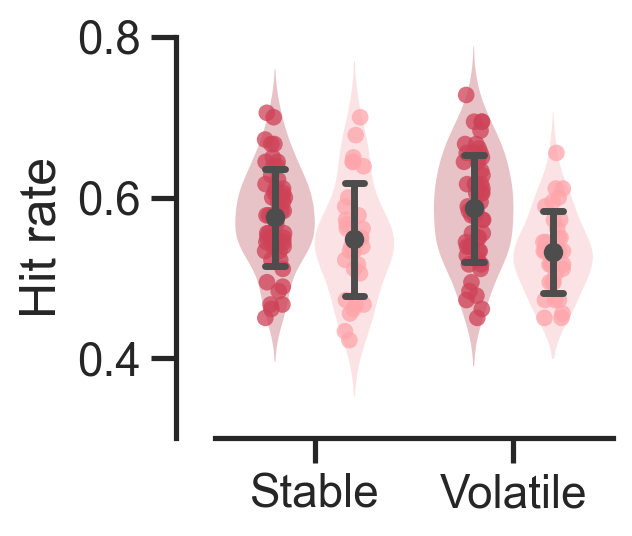

In [11]:
get_hit_rate(data)
plt.savefig('../figures/Fig2A_hit_rate.pdf', dpi=300)

## Hit rate difference

In [11]:
def get_adaptation(data):
    sel_data = data.groupby(by=['sub_id', 'trial_type', 'group'])[['hit', 'g']].mean().reset_index()
    p_table  = sel_data.pivot_table(
                    columns='trial_type',
                    index=['sub_id', 'group'],
                    values='hit',
                    aggfunc='mean',
                ).reset_index()
    p_table['adaptation'] = p_table['vol'] - p_table['sta']
    # t-test
    x_data = p_table.query('group=="HC"')['adaptation']
    y_data = p_table.query('group=="PAT"')['adaptation']
    t_test(x_data, y_data)
    # correlation
    comb_data = p_table.merge(sel_data, on=['sub_id', 'group'], how='left').groupby(
    by=['sub_id', 'group'])[['g', 'adaptation']].mean().reset_index()
    corr(comb_data['adaptation'], comb_data['g'])
    fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
    ax = axs[0]
    viz.violin(ax, data=p_table, y='adaptation', 
            x='group', order=['HC', 'PAT'],
            palette=viz.PurplePairs,
            scatter_alpha=.75, scatter_size=6,
            errorbar='sd', mean_marker_size=7,
            err_capsize=0.2)
    ax.set_box_aspect(1.5)
    ax.set_ylabel('Hit rate difference\n(hit volatile - hit stable)')
    ax.set_xlabel('')
    ax.spines['left'].set_position(('axes',-0.1))

    ax = axs[1]
    comb_data = comb_data.dropna()
    linear_regression(x=comb_data['g'].values, 
                    y=comb_data['adaptation'].values, 
                    add_intercept=True)
    sns.scatterplot(x='g', y='adaptation', data=comb_data, 
                    s=35, alpha=.95, lw=.5, ax=ax)
    sns.regplot(x='g', y='adaptation', data=comb_data, 
                    truncate=False,
                    color=[.2, .2, .2], scatter=False, ax=ax)
    ax.spines['left'].set_position(('axes',-0.1))
    ax.set_box_aspect(1)
    ax.set_xlabel('General factor')
    ax.set_xticks([-1, 0, 1, 2])
    ax.set_ylim([-.18, .18])
    fig.tight_layout()


 	t(55.648)=2.038, p=0.046, cohen-d=0.478
 	r(86)=-0.194, p=0.074
	y=-0.010x+0.004,
	p=0.074


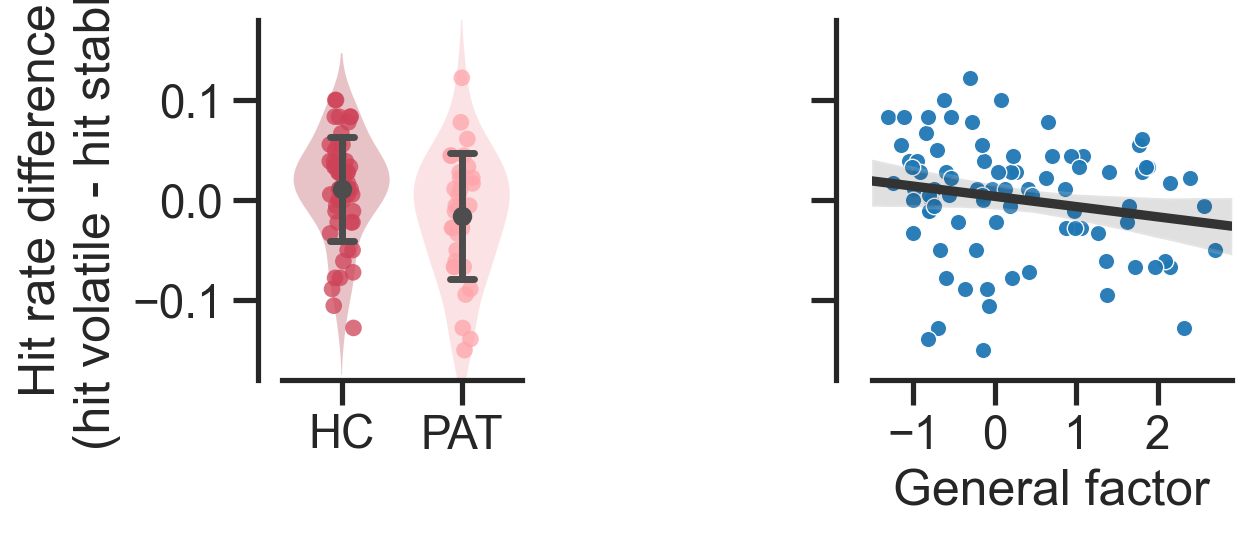

In [12]:
get_adaptation(data)

## Learning curves

In [17]:
fname = '../data/exp1data.pkl'
with open(fname, 'rb')as handle: fit_sub_info = pickle.load(handle)

In [18]:
def get_a_remap(block_data):
    psi_type = block_data['psi_type'].unique()[0]
    if psi_type=='vol8-sta3':
        block1 = 1-block_data['a'].values[90:]
        block2 = 1-block_data['a'].values[:90]
    elif psi_type=='sta3-vol8':
        block1 = 1-block_data['a'].values[:90]
        block2 = 1-block_data['a'].values[90:]
    elif psi_type=='vol2-sta7': 
        block1 = block_data['a'].values[90:]
        block2 = block_data['a'].values[:90]
    elif psi_type=='sta7-vol2':
        block1 = block_data['a'].values[:90]
        block2 = block_data['a'].values[90:]
    a_remap = np.hstack([block1, block2])
    if block_data['feedback_type'].unique()[0]=='loss':
        a_remap = 1 - a_remap
    block_data['a_remap'] = a_remap
    block_data['trial']   = np.arange(0, 180)
    return block_data

In [20]:
data = []
for sub_id, item in fit_sub_info.items():
    if sub_id in valid_sub_lst:
        for block_id, block_data in item.items():
            block_data = get_a_remap(block_data)
            data.append(block_data.copy())
data = pd.concat(data, axis=0)
data['group'] = data['group'].map({'HC': 'HC', 'MDD': 'PAT', 'GAD': 'PAT'})

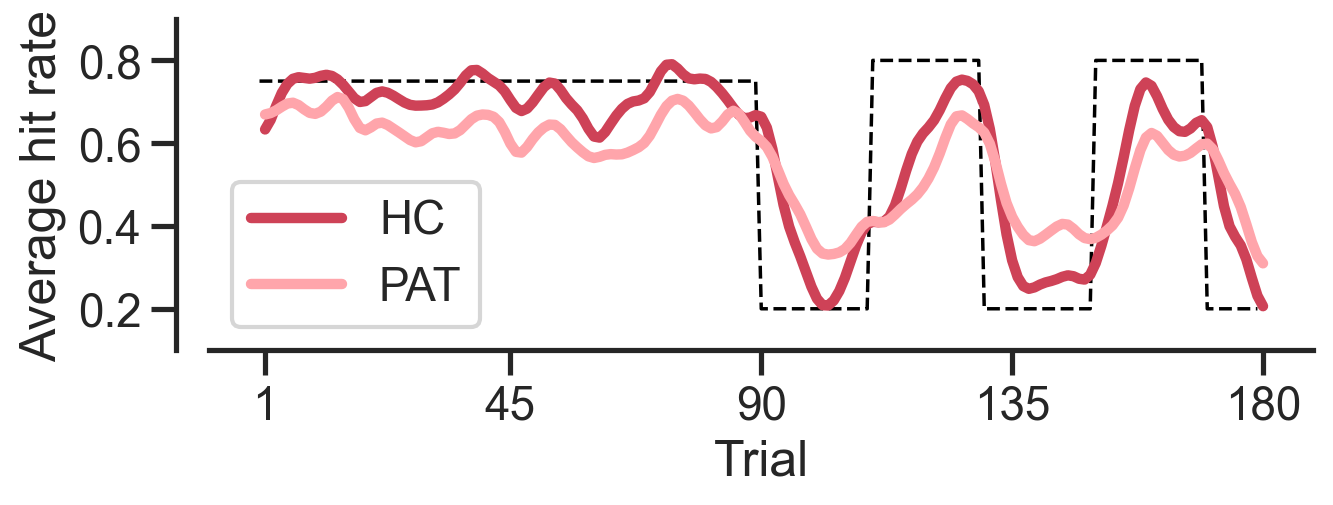

In [22]:
psi  = np.zeros([180])
psi[:90]     = .75
psi[90:110]  = .2
psi[110:130] = .8
psi[130:150] = .2
psi[150:170] = .8
psi[170:180] = .2
fig, ax = plt.subplots(1, 1, figsize=(7, 3))
sel_data = data.groupby(by=['trial', 'group'])['a_remap'].mean().reset_index()
smooth_data = {'a': [], 'group': [], 'trial': []}
for g in ['HC', 'PAT']:
    smooth = gaussian_filter1d(sel_data.query(f'group=="{g}"')['a_remap'], sigma=2)
    n = smooth.shape[0]
    smooth_data['a'] += smooth.tolist()
    smooth_data['group'] += [g]*n
    smooth_data['trial'] += list(range(1, n+1))
smooth_data = pd.DataFrame.from_dict(smooth_data)
sns.lineplot(x='trial', y='a', data=smooth_data,
            hue='group', hue_order=['HC', 'PAT'], palette=viz.PurplePairs,
            lw=3.75,
            ax=ax)
sns.lineplot(x=np.arange(180), y=psi, color='k', ls='--', lw=1.25, ax=ax, zorder=-10)
ax.set_box_aspect(.3)
ax.spines['left'].set_position(('axes',-0.03))
ax.set_ylim([.1, .9])
ax.set_yticks([.2, .4, .6, .8])
ax.set_xticks([1, 45, 90, 135, 180])
ax.set_ylabel('Average hit rate')
ax.set_xlabel('Trial')
fig.tight_layout()
plt.savefig('../figures/Fig2D_learning_curve.pdf', dpi=300)